# Titanic Dataset
### Aim is to predict whether a passenger on the titanic survived with data such as their age and gender.

### Outcome: Acheived an accuracy of 0.76 after submitting my predictions on the test data to the kaggle competition.

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from sklearn.feature_selection import mutual_info_classif
import seaborn as sns

# Meaning of Columns in Data
- survival: Survival, 0 = No, 1 = Yes
- pclass: Ticket class. 1 = 1st, 2 = 2nd, 3 = 3rd
- sex: Sex	
- Age: Age in years	
- sibsp: # of siblings / spouses aboard the Titanic	
- parch: # of parents / children aboard the Titanic	
- ticket: Ticket number	
- fare: Passenger fare	
- cabin: Cabin number	
- embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

In [139]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
df_test['Survived'] = np.NaN
df_train['train_test'] = 1
df_test['train_test'] = 0
df_all = pd.concat([df_train, df_test])

In [140]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test'],
      dtype='object')

In [141]:
numeric_columns = ['Fare', 'Age', 'SibSp', 'Parch']
df_train_num = df_train[numeric_columns]
df_train_cat = df_train.drop(numeric_columns, axis=1)

# Univariate Experimental Data Analysis
## Distributions of numerical data

Things to note:
- Fare has left-skewed distribution
- Age has roughly normal distribution

In [142]:
def plot_distributions():
    df_train_num_subset = df_train_num[['Fare', 'Age']]
    fig, ax = plt.subplots(df_train_num_subset.shape[1], figsize=(5,5))

    for i in range(df_train_num_subset.shape[1]):
        column = df_train_num_subset.columns[i]
        ax[i].hist(df_train_num_subset[column], bins=20)
        ax[i].set_title(column)

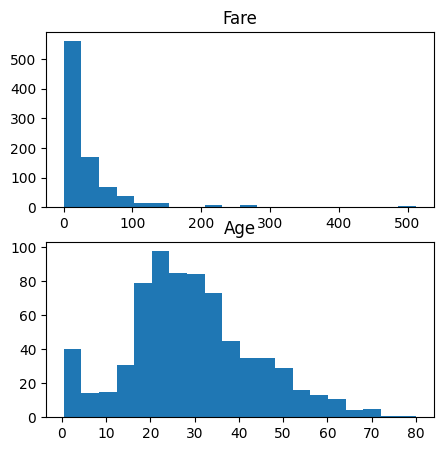

In [143]:
plot_distributions()

## Value counts for categorical data

To note:
- More people die than survive
- More males than females
- More people in 3rd class than in any other class

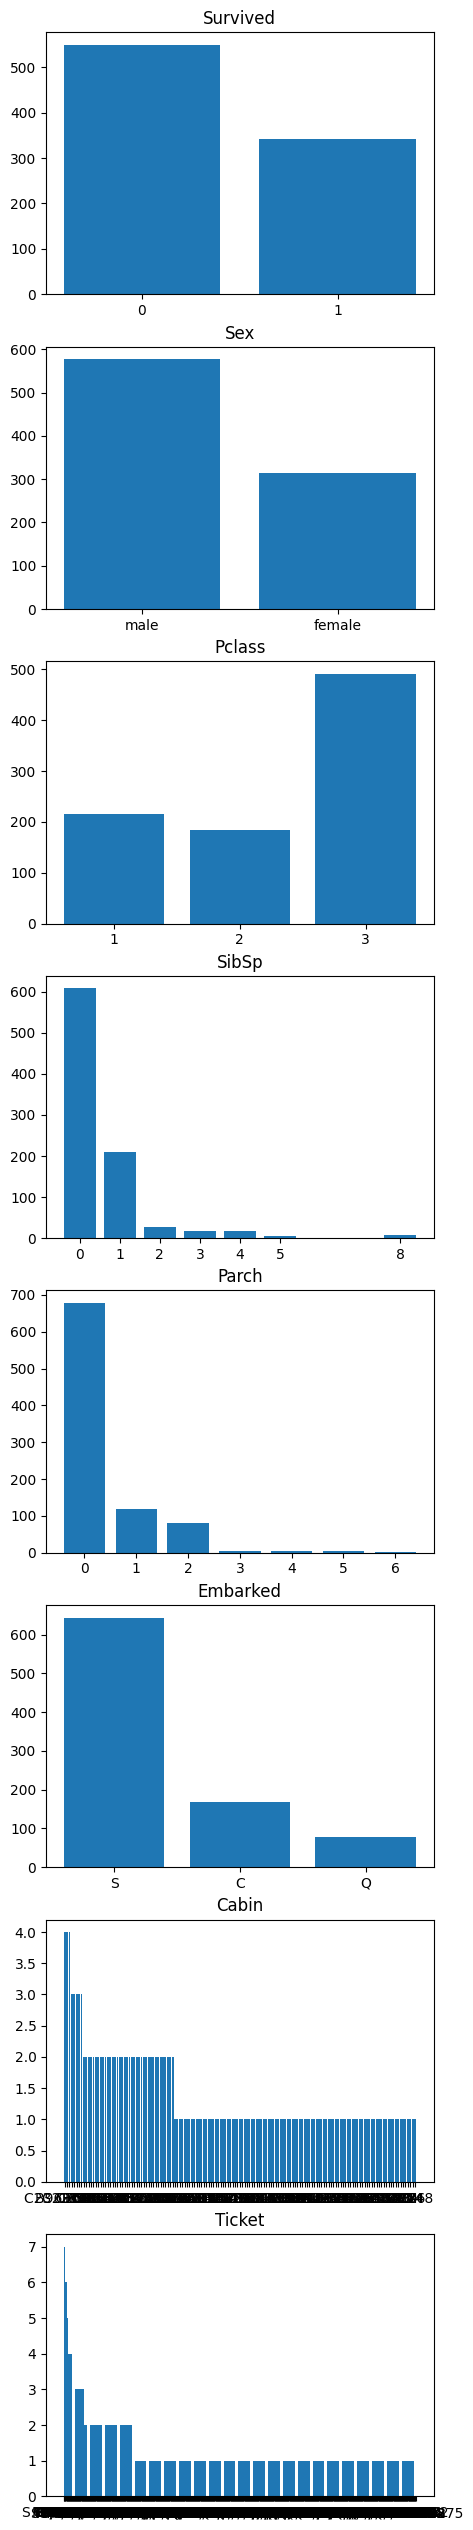

In [144]:
def plot_value_counts():
    df_train_subset = df_train[['Survived', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'Cabin', 'Ticket']]
    fig, ax = plt.subplots(df_train_subset.shape[1], figsize=(5, df_train_subset.shape[1] * 4))

    for i in range(df_train_subset.shape[1]):
        column = df_train_subset.columns[i]
        value_counts = df_train_subset[column].value_counts()
        ax[i].bar(x=value_counts.index, height=value_counts.values)
        ax[i].set_xticks(value_counts.index)
        ax[i].set_title(column)

plot_value_counts()

## Correlation between numerical features

In [145]:
correlations = df_train[['Age', 'Fare', 'Parch', 'SibSp']].corr()

<AxesSubplot: >

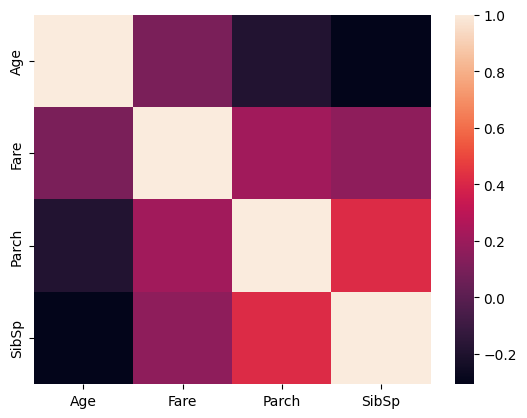

In [146]:
sns.heatmap(correlations)

# Imputing missing values
- The missing values of age are imputed with the mean age
- Those of Embarked are imputed with the mode of this column

In [147]:
df_all.Age = df_all.Age.fillna(df_all.Age.mean())

df_all.Embarked = df_all.Embarked.fillna(value='S')

## Imputing Fare values which are 0
Since fare cannot equal 0, these are imputed with the median fare value (since the distribution of Fare is skewed)

In [148]:
def median_fare_values(fare, median):
    if fare == 0:
        return median
    else:
        return fare

In [149]:
median_fare = df_train.Fare.median()

In [150]:
df_train.Fare = df_train.Fare.apply(median_fare_values, median=median_fare)
df_all.Fare = df_all.Fare.apply(median_fare_values, median=median_fare)

### Investigating significance of person's cabin letter

In [152]:
from cmath import nan

def get_unique_cabin_letters(cabin_string):
    if type(cabin_string) == str:
        return tuple(set([substring[0] for substring in cabin_string.split(' ')]))
    if type(cabin_string) == float:
        return nan

In [153]:
df_train['cabin_letter'] = df_train.Cabin.apply(get_unique_cabin_letters)

In [154]:
df_cabin_letter = df_train.groupby('cabin_letter')[['Survived']].mean()
df_cabin_letter['count'] = df_train.cabin_letter.value_counts()
df_cabin_letter

,Survived,count
cabin_letter,,
"(A,)",0.466667,15
"(B,)",0.744681,47
"(C,)",0.593220,59
"(D,)",0.757576,33
"(E,)",0.750000,32
"(F,)",0.777778,9
"(F, E)",1.000000,1
"(F, G)",0.000000,3
"(G,)",0.500000,4


The maximum difference in survival chance between most common cabins is 15%. This shows being in a certain cabin does not hugely impace survival chance. Moreover, there are large number of missing values. For these reasons, cabin_letter and Cabin are dropped.

In [155]:
df_train.drop('cabin_letter', axis=1, inplace=True)

### Investigating significance of title in name

In [156]:
df_train.Name.value_counts()

Braund, Mr. Owen Harris                     1
Boulos, Mr. Hanna                           1
Frolicher-Stehli, Mr. Maxmillian            1
Gilinski, Mr. Eliezer                       1
Murdlin, Mr. Joseph                         1
                                           ..
Kelly, Miss. Anna Katherine "Annie Kate"    1
McCoy, Mr. Bernard                          1
Johnson, Mr. William Cahoone Jr             1
Keane, Miss. Nora A                         1
Dooley, Mr. Patrick                         1
Name: Name, Length: 891, dtype: int64

In [157]:
# TODO: Investigate significance of title in name

# Feature Engineering

### Finding the number of relations of a person

In [158]:
df_train['num_relations'] = df_train.SibSp + df_train.Parch
df_all['num_relations'] = df_all.SibSp + df_all.Parch
df_train.num_relations.value_counts()

# TODO: Set binary as to whether or not a person is a child. Probably increases chances of survival.

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: num_relations, dtype: int64

In [159]:
df_all['is_child'] = df_all.Age.apply(lambda age: age < 18)

## Normalizing Fare Column
Currently Fare is left skewed. It should be normalized, e.g. if any model assumes its inputs have a normal distribution.

Boxcox seems more effective at normalizing the data, so it is used

In [160]:
df_train_Fare_boxcox = pd.Series(stats.boxcox(df_train.Fare)[0])
df_train_Fare_log = np.log(df_train.Fare + 1)

Text(0.5, 1.0, 'log')

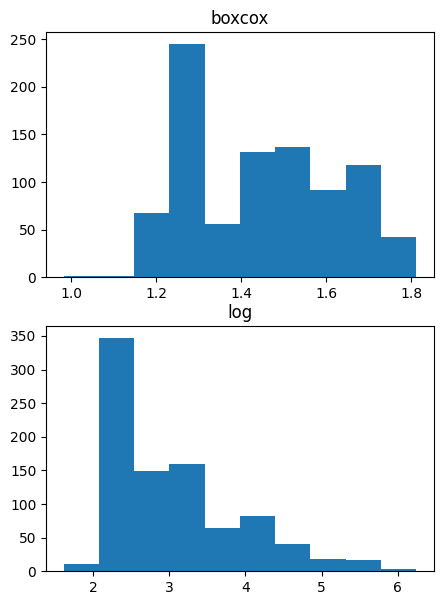

In [161]:
fig, ax = plt.subplots(2, figsize=(5, 7))

ax[0].hist(x=df_train_Fare_boxcox)
ax[0].set_title('boxcox')
ax[1].hist(x=df_train_Fare_log)
ax[1].set_title('log')

In [162]:
df_all.Fare = pd.Series(stats.boxcox(df_all.Fare)[0])

## Dropping unused columns

In [163]:
columns_to_drop = ['Cabin', 'Name', 'Ticket']
df_all.drop(columns_to_drop, axis=1, inplace=True)
df_train_cat.drop(columns_to_drop, axis=1, inplace=True)

## How categorical variables affect chance of survival

Things to note:
- Moving up the classes means more likely to survive
- Much higher chance of survival if female

In [164]:
for column in ['Pclass', 'Sex', 'Embarked', 'Parch', 'SibSp', 'num_relations']:
    print(df_train.groupby(column)[['Survived']].mean())

        Survived
Pclass          
1       0.629630
2       0.472826
3       0.242363
        Survived
Sex             
female  0.742038
male    0.188908
          Survived
Embarked          
C         0.553571
Q         0.389610
S         0.336957
       Survived
Parch          
0      0.343658
1      0.550847
2      0.500000
3      0.600000
4      0.000000
5      0.200000
6      0.000000
       Survived
SibSp          
0      0.345395
1      0.535885
2      0.464286
3      0.250000
4      0.166667
5      0.000000
8      0.000000
               Survived
num_relations          
0              0.303538
1              0.552795
2              0.578431
3              0.724138
4              0.200000
5              0.136364
6              0.333333
7              0.000000
10             0.000000


In [165]:
for column in ['Pclass', 'Sex', 'Embarked']:
    print(df_train.groupby(column)[['Fare']].mean())

             Fare
Pclass           
1       84.489275
2       21.133516
3       13.793303
             Fare
Sex              
female  44.479818
male    25.899653
               Fare
Embarked           
C         59.954144
Q         13.276030
S         27.416478


In [166]:
for column in ['Pclass', 'Sex', 'Embarked']:
    print(df_train.groupby(column)[['Age']].mean())

              Age
Pclass           
1       38.233441
2       29.877630
3       25.140620
              Age
Sex              
female  27.915709
male    30.726645
                Age
Embarked           
C         30.814769
Q         28.089286
S         29.445397


Pivot table below shows:
- Very high chance of survival for women in 1st and 2nd class.
- Very low chance of survival for men in 2nd and 3 class.

In [167]:
df_train_cat.pivot_table('Survived', index='Sex', columns='Pclass')

Pclass,1,2,3
Sex,,,
female,0.968085,0.921053,0.500000
male,0.368852,0.157407,0.135447


## Mutual Information

In [168]:
df_train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'train_test',
       'num_relations'],
      dtype='object')

In [169]:
X_train = df_all[df_all.train_test == 1].copy()
X_train = X_train.drop(['train_test', 'PassengerId'], axis=1)

X_test = df_all[df_all.train_test == 0].copy()
X_test = X_test.drop(['train_test', 'PassengerId', 'Survived'], axis=1)

y_train = X_train.pop('Survived')

for X in [X_train, X_test]:

    for col in X.select_dtypes('object'):
        X[col], _ = X[col].factorize()

discrete_features_train = X_train.dtypes == int

discrete_features_test = X_test.dtypes == int

In [170]:
mi_scores = mutual_info_classif(X_train, y_train, discrete_features=discrete_features_train)

In [171]:
mi_scores = pd.Series(mi_scores, index=X_train.columns)
mi_scores = mi_scores.sort_values(ascending=False)

mi_scores

Sex              0.151336
Fare             0.079117
Pclass           0.067155
num_relations    0.026221
Parch            0.014740
SibSp            0.014470
Age              0.012404
Embarked         0.000000
is_child         0.000000
dtype: float64

## Model Selection

In [172]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [173]:
model_dict = {'gnb': GaussianNB(),
'lr' : LogisticRegression(),
'knc' : KNeighborsClassifier(),
'rfc' : RandomForestClassifier(),
'svc' :SVC()}

for model in model_dict:
    print(model)
    print(model_dict[model].get_params())
    score = cross_val_score(model_dict[model], X_train, y_train, cv=5).mean()
    print(score)

gnb
{'priors': None, 'var_smoothing': 1e-09}
0.6229113050028247
lr
{'C': 1.0, 'class_weight': None, 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l2', 'random_state': None, 'solver': 'lbfgs', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
0.6161634548992531
knc
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.6914255225660663
rfc
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


c:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\Charlie\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_mo

0.8137153976523759
svc
{'C': 1.0, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': None, 'shrinking': True, 'tol': 0.001, 'verbose': False}
0.6195342414161069


## Finding Optimal Model Hyperparameters
Since the Random Forest Classifier achieved the highest accuracy of 0.81 (see above), will choose hyperparameters for it to try to improve.

Will use a coarse randomized search with 10 iterations.

In [174]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

params_dict = {'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

n_iterations = 10

model_random_search = RandomizedSearchCV(
    estimator=model_dict['rfc'],
    param_distributions=params_dict,
    n_iter=n_iterations
)

search = model_random_search.fit(X_train, y_train)

# TODO: A grid search to perform a finer search around the optimum found with random search 

In [175]:
print(f'The best parameters found in the random search were: {search.best_params_}')
print(f'The accuracy with these parameters is {search.best_score_}')

{'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 80}
0.8339087314041805


## Submission to kaggle acheived an accuracy of 0.76

In [176]:
y_hat = search.best_estimator_.predict(X_test).astype(int)
submission = pd.DataFrame({'PassengerId': df_test.PassengerId, 'Survived': y_hat})
submission.to_csv('submission.csv', index=False)